In [3]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

/home/jorge/miniconda3/envs/spyder-env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jorge/miniconda3/envs/spyder-env/lib/python3.10/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


torchvision tensors with annotations:
 -  Mask for segments

draw_segmentation_masks() to draw it.


In [4]:
# Define path to store datasets
dataset_dir = Path("./frame_labels_coco/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../augmentation/Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

In [5]:
 # Assuming the images are stored in a subfolder named 'images'
img_dir = dataset_dir/'../Unlabeled-videos/'

# Assuming the annotation file is in JSON format and located in a subdirectory of the dataset
annotation_file_path = list(dataset_dir.glob('*.json'))[0]

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

In [6]:
# Read the JSON file into a DataFrame, assuming the JSON is oriented by index
dataset = pd.read_json(annotation_file_path, orient='index').transpose()
dataset.head()

images  \
0  {'height': 1080, 'width': 1920, 'id': 1, 'file_name': '/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg'}   
1      {'height': 1080, 'width': 1920, 'id': 2, 'file_name': '/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera2/20230605_193537_tp00017/Annotations/..\00000041.jpg'}   
2  {'height': 1080, 'width': 1920, 'id': 3, 'file_name': '/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230710_133146_tp00000/Annotations/../00017304.jpg'}   
3       {'height': 720, 'width': 1280, 'id': 4, 'file_name': '/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera2/20230527_133530_tp00056/Annotations/../00012235.jpg'}   
4  {'height': 1080, 'width': 1920, 'id': 5, 'file_name': '/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230710_133146_tp00000/Annotations/../00005590.jpg'}   

                                                                                                                                                                                                                                                                                                                                                                                                                                      annotations  \
0                                                               {'iscrowd': 0, 'image_id': 1, 'bbox': [595.0, 530.0, 213.0, 252.0], 'segmentation': [[655, 672, 636, 709, 627, 747, 654, 768, 675, 782, 721, 781, 763, 775, 786, 750, 808, 721, 797, 679, 780, 663, 725, 621, 717, 599, 715, 587, 727, 545, 705, 586, 695, 597, 664, 577, 595, 530, 615, 552, 637, 572, 670, 593, 687, 606, 671, 643]], 'category_id': 1, 'id': 1, 'area': 23050}   
1                                                                                                                                                                     {'iscrowd': 0, 'image_id': 1, 'bbox': [1414.0, 50.0, 138.0, 33.0], 'segmentation': [[1425, 66, 1416, 72, 1414, 68, 1422, 62, 1431, 51, 1446, 50, 1452, 52, 1470, 55, 1501, 53, 1552, 67, 1524, 74, 1492, 83, 1463, 81, 1436, 79]], 'category_id': 1, 'id': 2, 'area': 2793}   
2                             {'iscrowd': 0, 'image_id': 1, 'bbox': [1143.0, 274.0, 120.0, 65.0], 'segmentation': [[1150, 325, 1143, 328, 1152, 332, 1190, 339, 1200, 337, 1224, 336, 1234, 336, 1250, 333, 1263, 329, 1252, 298, 1248, 291, 1259, 286, 1245, 281, 1235, 274, 1227, 279, 1219, 284, 1219, 295, 1219, 303, 1216, 305, 1207, 311, 1186, 309, 1170, 312, 1183, 313, 1199, 316, 1178, 322]], 'category_id': 1, 'id': 3, 'area': 3419}   
3                                                                                   {'iscrowd': 0, 'image_id': 1, 'bbox': [1357.0, 273.0, 201.0, 123.0], 'segmentation': [[1374, 283, 1386, 297, 1400, 309, 1419, 325, 1438, 348, 1357, 364, 1360, 369, 1448, 379, 1459, 387, 1502, 396, 1540, 386, 1548, 374, 1552, 370, 1558, 358, 1543, 345, 1527, 335, 1469, 327, 1439, 321, 1384, 274, 1377, 273]], 'category_id': 1, 'id': 4, 'area': 9190}   
4  {'iscrowd': 0, 'image_id': 1, 'bbox': [264.0, 587.0, 1001.0, 400.0], 'segmentation': [[834, 923, 715, 979, 573, 967, 508, 987, 452, 983, 411, 954, 345, 946, 336, 927, 266, 880, 264, 835, 294, 740, 312, 697, 366, 678, 475, 631, 635, 596, 710, 587, 865, 591, 1049, 589, 1180, 623, 1265, 672, 1198, 687, 1164, 738, 1137, 767, 1117, 802, 1049, 817, 1025, 836, 986, 850, 947, 892, 875, 922]], 'category_id': 0, 'id': 5, 'area': 274586}   

                                                                    categories  
0                           {'id': 0, 'name': 'Nest', 'supercategory': 'Nest'}  
1                   {'id': 1, 'name': 'Adult swift', 'supercategory': 'Swift'}  
2                   {'id': 2, 'name': 'Swift chick', 'supercategory': 'Swift'}  
3  {'id': 3, 'name': 'Fledgeling swift chick', 'supercategory': 'Swift chick'}  
4                 {'id': 4, 'name': 'Swift egg', 'superc

In [7]:
img_df = pd.DataFrame(list(dataset["images"].dropna()))

print(f"Number of Images: {len(img_df)}")

img_df.head()

Number of Images: 304


height  width  id  \
0    1080   1920   1   
1    1080   1920   2   
2    1080   1920   3   
3     720   1280   4   
4    1080   1920   5   

                                                                                                               file_name  
0  /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg  
1      /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera2/20230605_193537_tp00017/Annotations/..\00000041.jpg  
2  /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230710_133146_tp00000/Annotations/../00017304.jpg  
3      /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera2/20230527_133530_tp00056/Annotations/../00012235.jpg  
4  /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230710_133146_tp00000/Annotations/../00005590.jpg

In [8]:
categories_df = pd.DataFrame(list(dataset["categories"].dropna()))

print(f"Number of Categories: {len(categories_df)}")

categories_df.head()

Number of Categories: 6


id                    name supercategory
0   0                    Nest          Nest
1   1             Adult swift         Swift
2   2             Swift chick         Swift
3   3  Fledgeling swift chick   Swift chick
4   4               Swift egg     Swift egg

In [9]:
annotations_df = pd.DataFrame(list(dataset["annotations"].dropna()))
annotations_df['label'] = annotations_df['category_id'].apply(lambda x: categories_df.loc[x]['name'])
annotations_df.drop('id', axis=1, inplace=True)
annotations_df = pd.merge(annotations_df, img_df, left_on='image_id', right_on='id')
annotations_df.drop('id', axis=1, inplace=True)
annotations_df.set_index('image_id', inplace=True)


print(f"Number of Annotations: {len(annotations_df)}")

annotations_df.head()

Number of Annotations: 2501


iscrowd                           bbox  \
image_id                                           
1               0   [595.0, 530.0, 213.0, 252.0]   
1               0    [1414.0, 50.0, 138.0, 33.0]   
1               0   [1143.0, 274.0, 120.0, 65.0]   
1               0  [1357.0, 273.0, 201.0, 123.0]   
1               0  [264.0, 587.0, 1001.0, 400.0]   

                                                                                                                                                                                                                                                                                                           segmentation  \
image_id                                                                                                                                                                                                                                                                                                                  
1                                                                    [[655, 672, 636, 709, 627, 747, 654, 768, 675, 782, 721, 781, 763, 775, 786, 750, 808, 721, 797, 679, 780, 663, 725, 621, 717, 599, 715, 587, 727, 545, 705, 586, 695, 597, 664, 577, 595, 530, 615, 552, 637, 572, 670, 593, 687, 606, 671, 643]]   
1                                                                                                                                                                        [[1425, 66, 1416, 72, 1414, 68, 1422, 62, 1431, 51, 1446, 50, 1452, 52, 1470, 55, 1501, 53, 1552, 67, 1524, 74, 1492, 83, 1463, 81, 1436, 79]]   
1                                 [[1150, 325, 1143, 328, 1152, 332, 1190, 339, 1200, 337, 1224, 336, 1234, 336, 1250, 333, 1263, 329, 1252, 298, 1248, 291, 1259, 286, 1245, 281, 1235, 274, 1227, 279, 1219, 284, 1219, 295, 1219, 303, 1216, 305, 1207, 311, 1186, 309, 1170, 312, 1183, 313, 1199, 316, 1178, 322]]   
1                                                                                        [[1374, 283, 1386, 297, 1400, 309, 1419, 325, 1438, 348, 1357, 364, 1360, 369, 1448, 379, 1459, 387, 1502, 396, 1540, 386, 1548, 374, 1552, 370, 1558, 358, 1543, 345, 1527, 335, 1469, 327, 1439, 321, 1384, 274, 1377, 273]]   
1         [[834, 923, 715, 979, 573, 967, 508, 987, 452, 983, 411, 954, 345, 946, 336, 927, 266, 880, 264, 835, 294, 740, 312, 697, 366, 678, 475, 631, 635, 596, 710, 587, 865, 591, 1049, 589, 1180, 623, 1265, 672, 1198, 687, 1164, 738, 1137, 767, 1117, 802, 1049, 817, 1025, 836, 986, 850, 947, 892, 875, 922]]   

          category_id    area        label  height  width  \
image_id                                                    
1                   1   23050  Adult swift    1080   1920   
1                   1    2793  Adult swift    1080   1920   
1                   1    3419  Adult swift    1080   1920   
1                   1    9190  Adult swift    1080   1920   
1                   0  274586         Nest    1080   1920   

                                                                                                                      file_name  
image_id                                                                                                                         
1         /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg  
1         /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg  
1         /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg  
1         /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg  
1         /home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg

In [10]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

Image Dims: (1920, 1080)


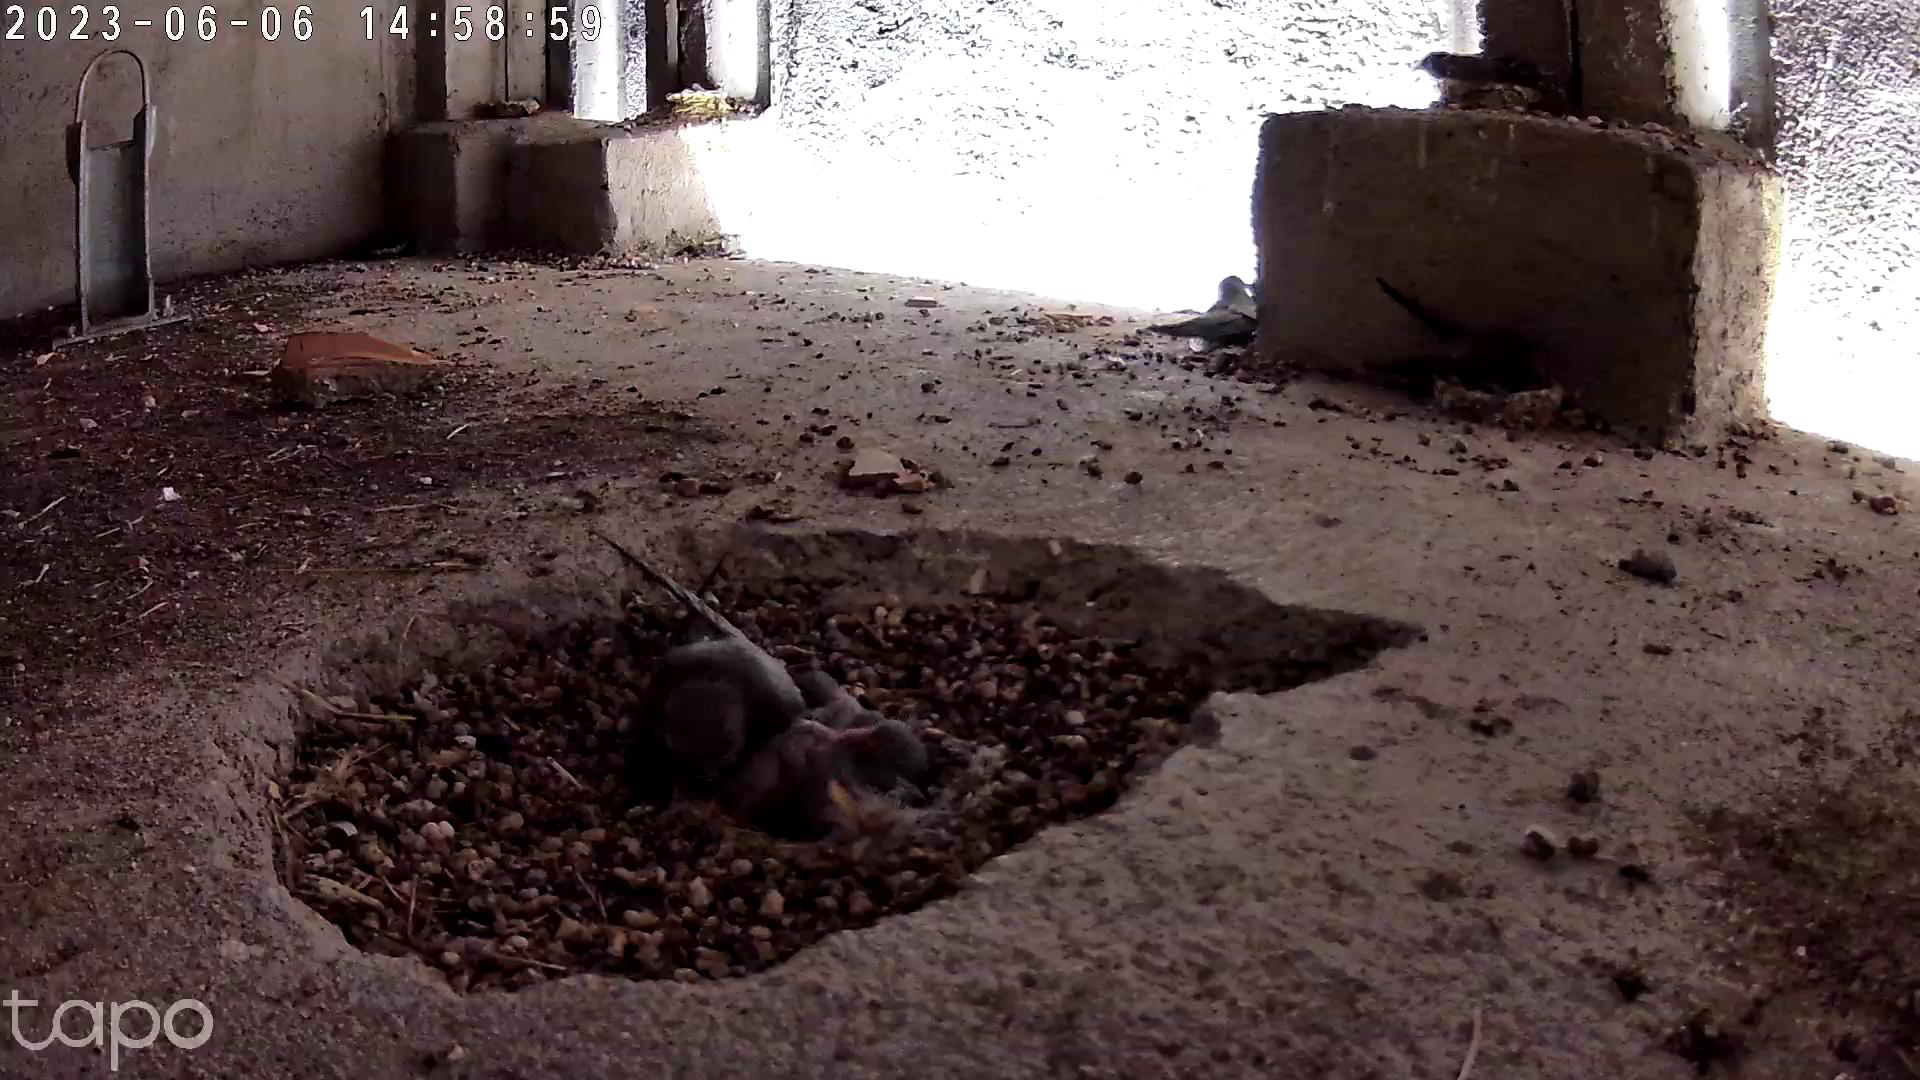

In [11]:
# Get the file ID of the first image file
file_id = img_df.loc[0, "id"]
file_name = img_df.loc[0, "file_name"]

# Open the associated image file as a RGB image
sample_img = Image.open(file_name).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotations_df['label'].explode().unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

# Show the image
sample_img

  0%|          | 0.00/130k [00:00<?, ?iB/s]

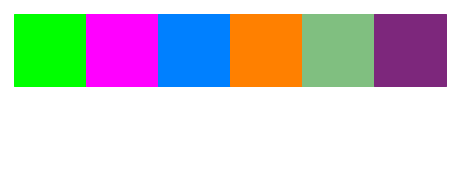

In [25]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

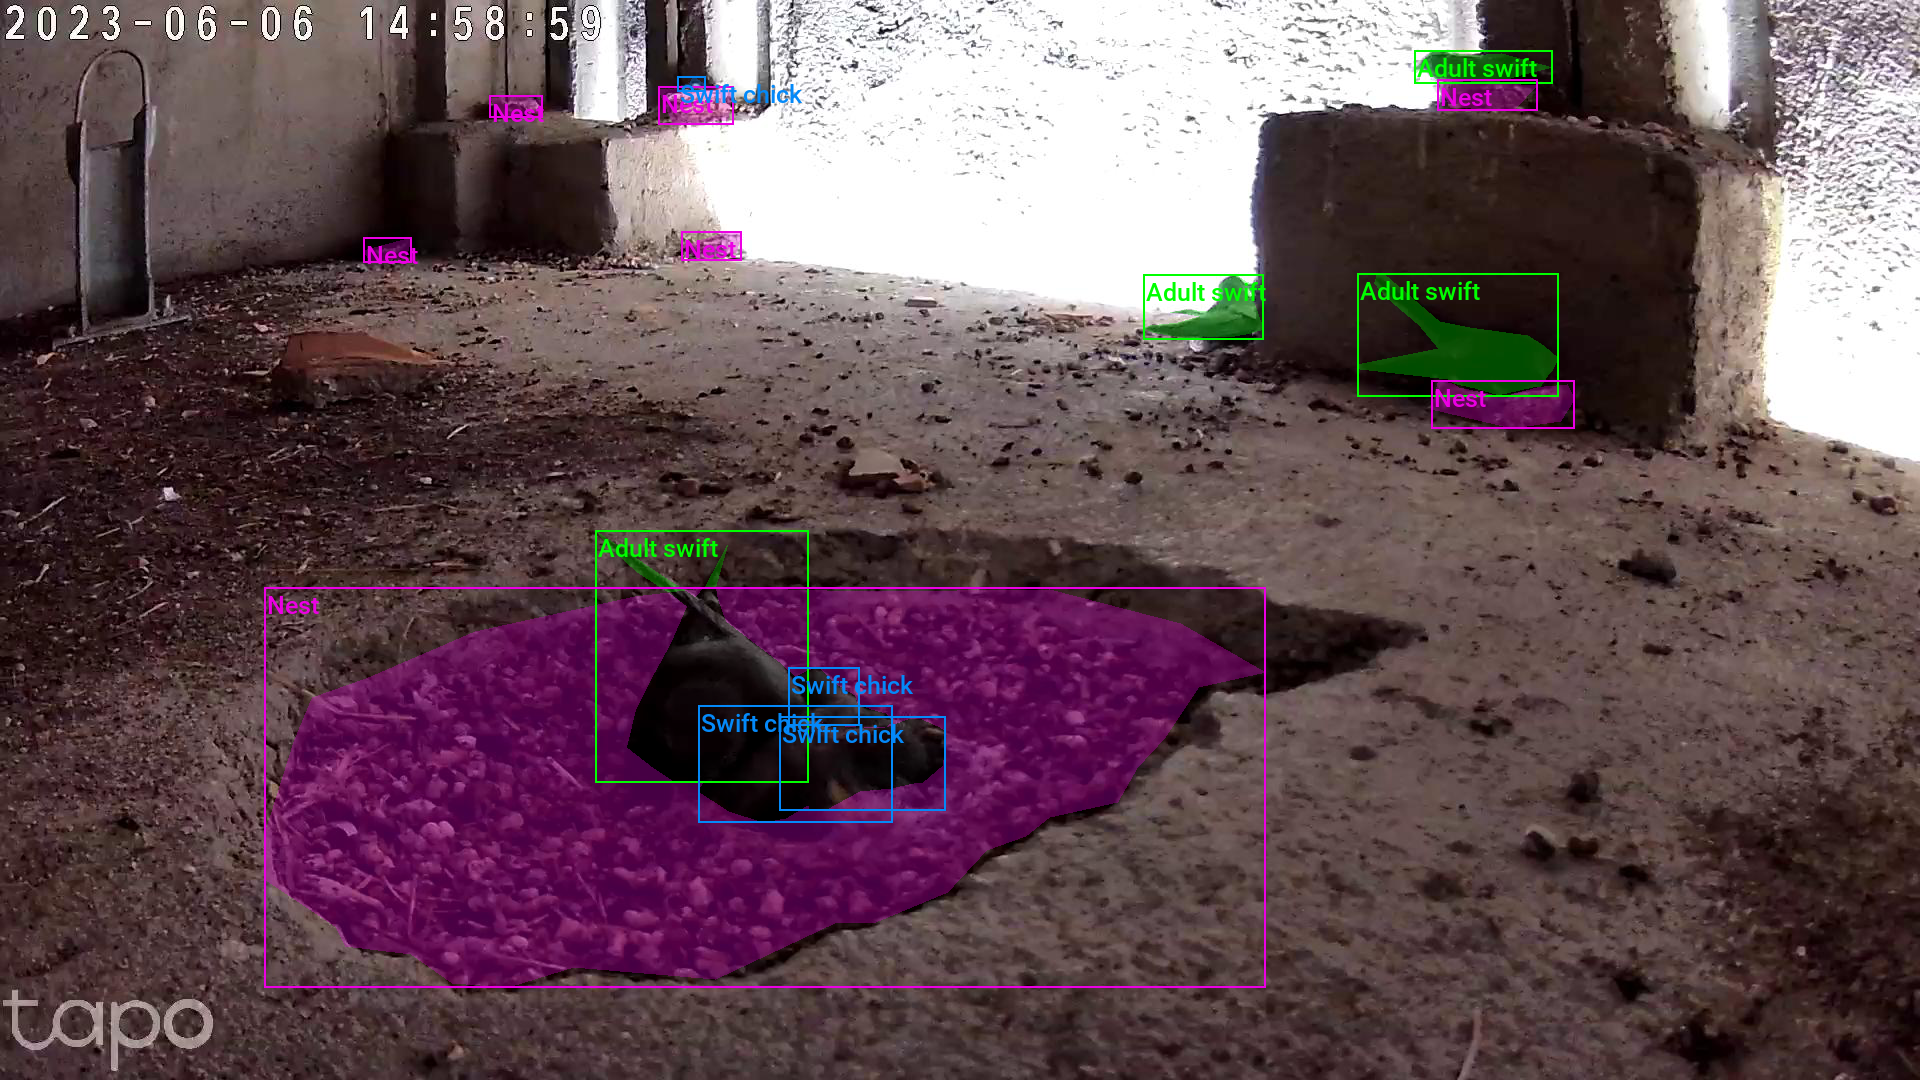

In [13]:
# Extract the polygon points for segmentation mask
polygon_points = annotations_df.loc[file_id]['segmentation']

# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, polygon[0]) for polygon in polygon_points]

# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

# Extract the labels and bounding box annotations for the sample image
labels = annotations_df.loc[file_id]['label']
bboxes = annotations_df.loc[file_id]['bbox']

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=torchvision.ops.box_convert(torch.Tensor(list(bboxes)), 'xywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

In [14]:
# Set training image size
train_sz = 384

In [15]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

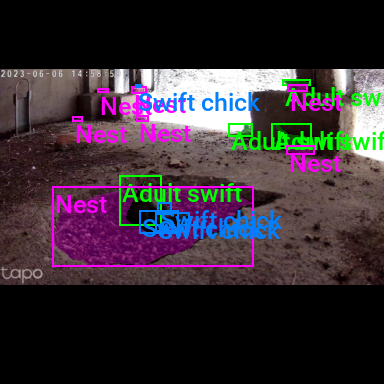

In [30]:
# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(np.vstack(bboxes.values)), 'xywh', 'xyxy'), 
                           format='xyxy', 
                           canvas_size=sample_img.size[::-1]), 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

In [89]:
class COCOInstSegDataset(Dataset):
    """
    A PyTorch Dataset class for COCO-style instance segmentation.

    This class is designed to handle datasets for instance segmentation tasks, specifically
    formatted in the style of COCO (Common Objects in Context) annotations. It supports
    loading images along with their corresponding segmentation masks and bounding boxes.

    Attributes:
    _img_keys : list
        List of image keys (identifiers).
    _annotation_df : pandas.DataFrame
        DataFrame containing annotations for images.
    _img_dict : dict
        Dictionary mapping image keys to their file paths.
    _class_to_idx : dict
        Dictionary mapping class names to class indices.
    _transforms : torchvision.transforms (optional)
        Transformations to be applied to the images and targets.

    Methods:
    __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        Initializes the dataset with image keys, annotations, image dictionary,
        class mappings, and optional transforms.
    __len__(self):
        Returns the total number of items in the dataset.
    __getitem__(self, index):
        Retrieves an image and its corresponding target (masks, boxes, labels) by index.
    _load_image_and_target(self, annotation):
        Loads an image and its corresponding target data based on the providedannotation.

    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the COCOInstSegDataset instance.

        Parameters:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame containing image annotations.
            img_dict (dict): Dictionary mapping image keys to file paths.
            class_to_idx (dict): Dictionary mapping class names to indices.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied

    def __len__(self):
        # Returns the number of items in the dataset
        return len(self._img_keys)
        
    def __getitem__(self, index):
        # Retrieves an image and its corresponding target by index
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        # Apply transformations if any
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        # Loads an image and its corresponding target data (masks, boxes, labels)
        filepath = annotation.name.iloc[0]
        print(filepath)
        image = Image.open(filepath).convert('RGB')

        # Process segmentation polygons
        polygon_points = annotation['segmentation']
        mask_imgs = [create_polygon_mask(image.size, polygon[0]) for polygon in polygon_points]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))
        
        # Convert bounding boxes to tensor format
        bbox_list = annotation['bbox']
        bbox_tensor = torchvision.ops.box_convert(torch.Tensor(np.vstack(bbox_list.values)), 'xywh', 'xyxy')
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
        
        # Map labels to their corresponding indices
        annotation_labels = annotation['label']
        labels = torch.Tensor([self._class_to_idx[label] for label in annotation_labels])
        
        return image, {'masks': masks, 'boxes': boxes, 'labels': labels}

In [90]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

img_dict =  img_df.set_index("id").to_dict()["file_name"]

In [91]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = COCOInstSegDataset(list(img_df["id"]), annotations_df,img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

In [92]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = COCOInstSegDataset(list(img_dict.keys()), annotations_df.rename({"file_name": "name"}, axis='columns'), img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

/home/shared/Swifts.Research.Project/Unlabeled-videos/Camera1/Day/20230606_145859_tp00001/Annotations/../00000008.jpg


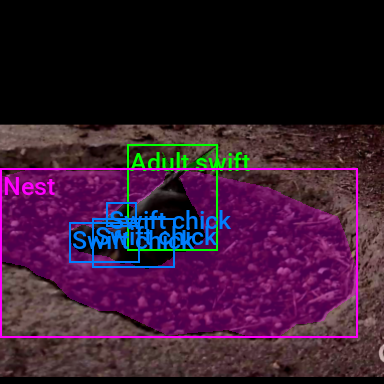

In [96]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)